# CPSC 330 - Applied Machine Learning 

## Homework 6: Putting it all together 
### Associated lectures: All material till lecture 13 

**Due date: Monday, November 15, 2021 at 11:59pm**

## Table of contents

- [Submission instructions](#si)
- [Understanding the problem](#1)
- [Data splitting](#2)
- [EDA](#3)
- (Optional) [Feature engineering](#4)
- [Preprocessing and transformations](#5)
- [Baseline model](#6)
- [Linear models](#7)
- [Different classifiers](#8)
- (Optional) [Feature selection](#9)
- [Hyperparameter optimization](#10)
- [Interpretation and feature importances](#11)
- [Results on the test set](#12)
- (Optional) [Explaining predictions](#13)
- [Summary of the results](#14)

## Imports 

In [28]:
import os

%matplotlib inline
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge, RidgeCV
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    plot_confusion_matrix,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC

<br><br>

## Instructions 
<hr>
rubric={points:2}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330/blob/master/docs/homework_instructions.md). 

**You may work on this homework in a group and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 3. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).

<br><br>

## Introduction <a name="in"></a>
<hr>

At this point we are at the end of supervised machine learning part of the course. So in this homework, you will be working on an open-ended mini-project, where you will put all the different things you have learned so far together to solve an interesting problem.

A few notes and tips when you work on this mini-project: 

#### Tips

1. This mini-project is open-ended, and while working on it, there might be some situations where you'll have to use your own judgment and make your own decisions (as you would be doing when you work as a data scientist). Make sure you explain your decisions whenever necessary. 
2. **Do not include everything you ever tried in your submission** -- it's fine just to have your final code. That said, your code should be reproducible and well-documented. For example, if you chose your hyperparameters based on some hyperparameter optimization experiment, you should leave in the code for that experiment so that someone else could re-run it and obtain the same hyperparameters, rather than mysteriously just setting the hyperparameters to some (carefully chosen) values in your code. 
3. If you realize that you are repeating a lot of code try to organize it in functions. Clear presentation of your code, experiments, and results is the key to be successful in this lab. You may use code from lecture notes or previous lab solutions with appropriate attributions. 
4. If you are having trouble running models on your laptop because of the size of the dataset, you can create your train/test split in such a way that you have less data in the train split. If you end up doing this, please write a note to the grader in the submission explaining why you are doing it.  

#### Assessment

We plan to grade fairly and leniently. We don't have some secret target score that you need to achieve to get a good grade. **You'll be assessed on demonstration of mastery of course topics, clear presentation, and the quality of your analysis and results.** For example, if you just have a bunch of code and no text or figures, that's not good. If you do a bunch of sane things and get a lower accuracy than your friend, don't sweat it.

#### A final note

Finally, this style of this "project" question is different from other assignments. It'll be up to you to decide when you're "done" -- in fact, this is one of the hardest parts of real projects. But please don't spend WAY too much time on this... perhaps "a few hours" (2-8 hours???) is a good guideline for a typical submission. Of course if you're having fun you're welcome to spend as much time as you want! But, if so, try not to do it out of perfectionism or getting the best possible grade. Do it because you're learning and enjoying it. Students from the past cohorts have found such kind of labs useful and fun and I hope you enjoy it as well. 

<br><br>

## 1. Understanding the problem <a name="1"></a>
<hr>
rubric={points:4}

In this mini project, you will be working on a classification problem of predicting whether a credit card client will default or not. 
For this problem, you will use [Default of Credit Card Clients Dataset](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset). In this data set, there are 30,000 examples and 24 features, and the goal is to estimate whether a person will default (fail to pay) their credit card bills; this column is labeled "default.payment.next.month" in the data. The rest of the columns can be used as features. You may take some ideas and compare your results with [the associated research paper](https://www.sciencedirect.com/science/article/pii/S0957417407006719), which is available through [the UBC library](https://www.library.ubc.ca/). 

**Your tasks:**

1. Spend some time understanding the problem and what each feature means. You can find this information in the documentation on [the dataset page on Kaggle](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset). Write a few sentences on your initial thoughts on the problem and the dataset. 
2. Download the dataset and read it as a pandas dataframe. 

1. My initial thoughts, after exploring the features, is that `PAY_[0-6]` are strong predictors of default payment. Intuitively, when a client consistently delays their payments, they are less likely to be able to pay off their debt, and thus will likely default. Another pattern I saw from examining the data is that clients who consistently had `PAY_AMT[1-6]` = 0 with `BILL_AMT[1-6]` > 0 were also likely to default.

In [29]:
df = pd.read_csv("./UCI_Credit_Card.csv")
df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000.0,1,3,1,39,0,0,0,0,...,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29996,29997,150000.0,1,3,2,43,-1,-1,-1,-1,...,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29997,29998,30000.0,1,2,2,37,4,3,2,-1,...,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29998,29999,80000.0,1,3,1,41,1,-1,0,0,...,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1


<br><br>

## 2. Data splitting <a name="2"></a>
<hr>
rubric={points:2}

**Your tasks:**

1. Split the data into train and test portions. 

In [30]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)

X_train = train_df.drop(columns=["default.payment.next.month"])
y_train = train_df["default.payment.next.month"]

X_test = test_df.drop(columns=["default.payment.next.month"])
y_test = test_df["default.payment.next.month"]

<br><br>

## 3. EDA <a name="3"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Perform exploratory data analysis on the train set.
2. Include at least two summary statistics and two visualizations that you find useful, and accompany each one with a sentence explaining it.
3. Summarize your initial observations about the data. 
4. Pick appropriate metric/metrics for assessment. 

### 3.1 Perform exploratory data analysis on the train set.

In [31]:
train_df.describe(include="all")

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,...,24000.000000,24000.000000,24000.000000,24000.000000,2.400000e+04,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000
mean,14964.174292,167893.486667,1.603125,1.851958,1.553375,35.488458,-0.017542,-0.135292,-0.170042,-0.224292,...,43389.105625,40297.970375,38708.777542,5656.319917,5.910454e+03,5280.658708,4763.854250,4805.837667,5277.577958,0.222167
std,8660.479272,130109.666875,0.489260,0.790560,0.521452,9.217424,1.125331,1.199812,1.201709,1.170630,...,64572.844994,60878.153831,59355.284889,16757.718059,2.134743e+04,17973.951980,15162.056345,15251.828322,18222.046645,0.415711
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-65167.000000,-61372.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7467.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2310.000000,1744.250000,1200.000000,990.000000,8.150000e+02,390.000000,281.750000,234.000000,110.750000,0.000000
50%,14975.000000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19032.000000,18019.000000,16812.500000,2100.000000,2.010000e+03,1801.500000,1500.000000,1500.000000,1500.000000,0.000000
75%,22460.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54591.500000,50237.250000,49132.750000,5009.000000,5.000000e+03,4600.000000,4026.000000,4009.250000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.227082e+06,896040.000000,621000.000000,426529.000000,528666.000000,1.000000


Initial insights: we may want to get rid of the `ID` column (since it just seems to be an identifier). We may also consider getting rid of the `SEX` column, since we don't want our model to be biased towards a certain gender.

In [32]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24000 entries, 19682 to 19966
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          24000 non-null  int64  
 1   LIMIT_BAL                   24000 non-null  float64
 2   SEX                         24000 non-null  int64  
 3   EDUCATION                   24000 non-null  int64  
 4   MARRIAGE                    24000 non-null  int64  
 5   AGE                         24000 non-null  int64  
 6   PAY_0                       24000 non-null  int64  
 7   PAY_2                       24000 non-null  int64  
 8   PAY_3                       24000 non-null  int64  
 9   PAY_4                       24000 non-null  int64  
 10  PAY_5                       24000 non-null  int64  
 11  PAY_6                       24000 non-null  int64  
 12  BILL_AMT1                   24000 non-null  float64
 13  BILL_AMT2                  

Looking at the values in the `Non-Null`, it seems that no column is missing any values. We most likely won't need to impute values, but having an imputation step won't hurt (in case there are some missing values in the test set)

In [33]:
train_df["PAY_0"].unique()

array([ 0, -1,  1,  4,  2, -2,  8,  3,  5,  6,  7])

### 3.2 Include at least two summary statistics and two visualizations that you find useful, and accompany each one with a sentence explaining it.

In [34]:
# TODO: which summary stats to choose from .describe()?


In [35]:
# plotting code below is inspired by the similar histogram question in hw2
def plot_single_hist(x_list, bins, labels, title, xlabel, alpha=1.0, histtype="bar"):
    for i in range(len(x_list)):
        plt.hist(x=x_list[i], bins=bins, alpha=alpha, label=labels[i], histtype=histtype)
    plt.legend(loc="upper right")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("count")
    plt.show()

In [36]:
X_train["PAY_0"].unique()

array([ 0, -1,  1,  4,  2, -2,  8,  3,  5,  6,  7])

In [37]:
# histogram on target values to show class dominance
# histograms on PAY_[0-6] and PAY_AMT[0-6] and their target values
# histogram of limit balance

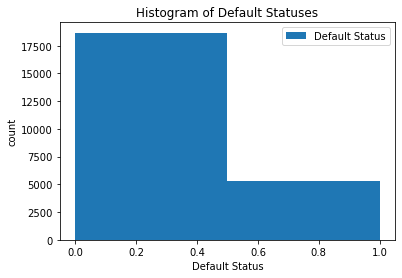

In [38]:
# plot histogram of the target class variable to check for class imbalance
plot_single_hist([y_train], 2, ["Default Status"], "Histogram of Default Statuses", "Default Status")

This histogram shows the distribution of the values of the target class variable which represents whether a client defaulted or not. From this histogram, we can observe that there is a clear class imbalance as there are many more examples of the negative class than of the positive class.

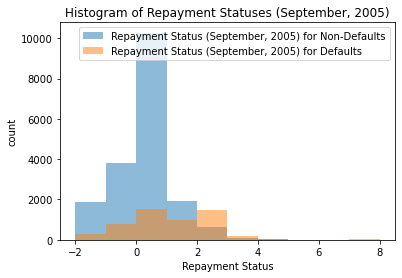

In [39]:
# retrieve all examples with negative and positive class labels separately
negative_examples = train_df[train_df["default.payment.next.month"] == 0]
positive_examples = train_df[train_df["default.payment.next.month"] == 1]

# plot histogram of Repayment Status in Sept 2005 for both target classes
plot_single_hist(
    [negative_examples["PAY_0"], positive_examples["PAY_0"]],
    10,
    ["Repayment Status (September, 2005) for Non-Defaults",
     "Repayment Status (September, 2005) for Defaults"],
    "Histogram of Repayment Statuses (September, 2005)",
    "Repayment Status",
    0.5,
    "barstacked"
)

This histogram shows the repayment status of clients in Sept, 2005 for both non-default and defaulted clients. A quick observation from this histogram is that clients that had more months of payment delays tend to default more than the clients that have less or zero payment delays.

### 3.3 Summarize your initial observations about the data.

- In this dataset, the positive class is when a client defaults, and the negative class is when a client does not default.
- False negatives (failing to predict default) could be more damaging, because the bank will not be able to recover the money they loaned the client in the form of credit.
   - In this case, measuring recall could be important because we do not want someone who will default to slip by the predictions (e.g. we want to minimize the number of false negatives - increase recall)
   - However, we also want to ensure that we favour predicting default correctly, therefore, prediction is also important.
- There is class imbalance, where non-default examples dominate. We can also see this by noticing that the mean of `default.payment.next.month` is closer to 0 than 1
   - Therefore, accuracy is likely not a good metric for assessment   


### 3.4 Pick appropriate metric/metrics for assessment.

We will primarily use **f1** as a metric for assessment.
- While recall is important as it allows us to measure the proportion of positive examples that are identified, we also need to ensure that our model correctly identifies positive examples, measured using precision. 
- This is because it is possible for our model to be extremely cautious and identify every client as likely to default, predicting all examples as positive; 
    - in such case, some predictions will undoubtedly be true positives (meaning TP > 0), and because we did not predict any negative cases, FN and TN will both be 0. 
    - Recall = TP / (TP + FN), so if TP > 0 and FN = 0, it means that recall = 1 when every client is predicted to have high default risk. 
    - If everyone is positive, then no one is positive, and our predictions would be meaningless. 
- We need to strike a balance between predicting positive samples (recall) and _correctly_ predicting positive samples (precision) - f1 would allow us to do that. 



<br><br>

## (Optional) 4. Feature engineering <a name="4"></a>
<hr>
rubric={points:1}

**Your tasks:**

1. Carry out feature engineering. In other words, extract new features relevant for the problem and work with your new feature set in the following exercises. You may have to go back and forth between feature engineering and preprocessing. 

<br><br>

## 5. Preprocessing and transformations <a name="5"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Identify different feature types and the transformations you would apply on each feature type. 
2. Define a column transformer, if necessary. 

### 5.1 Identify different feature types and the transformations you would apply on each feature type.

In [40]:
drop_features = [
    "ID",
    "SEX"
]
numeric_features = [
    "LIMIT_BAL",
    "AGE", 
    "BILL_AMT1",
    "BILL_AMT2",
    "BILL_AMT3",
    "BILL_AMT4",
    "BILL_AMT5",
    "BILL_AMT6",
    "PAY_AMT1",
    "PAY_AMT2",
    "PAY_AMT3",
    "PAY_AMT4",
    "PAY_AMT5",
    "PAY_AMT6",
]

categorical_features = [
    "EDUCATION",
    "MARRIAGE",
    "PAY_0",
    "PAY_2",
    "PAY_3",
    "PAY_4",
    "PAY_5",
    "PAY_6",
]
"""
Note that we do not need ordinal encoder for PAY_[0-6] because the encoder will just change the ordering to integers, which is ordering that the columns already have.
"""

'\nNote that we do not need ordinal encoder for PAY_[0-6] because the encoder will just change the ordering to integers, which is ordering that the columns already have.\n'

### 5.2 Define a column transformer, if necessary.

In [41]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse=False)
preprocessor = make_column_transformer(
    ("drop", drop_features),
    (numeric_transformer, numeric_features),
    (categorical_transformer, categorical_features),
)

<br><br>

## 6. Baseline model <a name="6"></a>
<hr>

rubric={points:2}

**Your tasks:**
1. Try `scikit-learn`'s baseline model and report results.

In [42]:
scoring = [
    "accuracy",
    "f1",
    "recall",
    "precision",
]

In [43]:
dummy = DummyClassifier()
dummy_scores = cross_validate(dummy, X_train, y_train, cv=10, return_train_score=True)
pd.DataFrame(dummy_scores)

,fit_time,score_time,test_score,train_score
0,0.002852,0.000419,0.777917,0.777824
1,0.004113,0.000612,0.777917,0.777824
2,0.004891,0.000869,0.777917,0.777824
3,0.005005,0.000933,0.777917,0.777824
4,0.003315,0.001018,0.777917,0.777824
5,0.003510,0.000500,0.777917,0.777824
6,0.003309,0.000499,0.777917,0.777824
7,0.002983,0.000501,0.777917,0.777824
8,0.002920,0.000472,0.777500,0.777870
9,0.004509,0.000876,0.777500,0.777870


In [44]:
print("Mean train accuracy =", dummy_scores["train_score"].mean())
print("Mean validation accuracy =", dummy_scores["test_score"].mean())

Mean train accuracy = 0.7778333333333333
Mean validation accuracy = 0.7778333333333334


The train/validation accuracies of the baseline model is high, but because default cases are rare and there are many more examples of non-default cases, accuracy is not an informative metric.

<br><br>

## 7. Linear models <a name="7"></a>
<hr>
rubric={points:12}

**Your tasks:**

1. Try logistic regression as a first real attempt. 
2. Carry out hyperparameter tuning to explore different values for the complexity hyperparameter `C`. 
3. Report validation scores along with standard deviation. 
4. Summarize your results.

### 7.1 Try logistic regression as a first real attempt.

In [45]:
# directly pasted from HW3's provided code
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.6f (+/- %0.6f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

def get_mean(text, delimiter):
    return float(text.split(delimiter, 1)[0])

In [46]:
lr_pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=2000))
lr_results = mean_std_cross_val_scores(
    lr_pipe, X_train, y_train, cv=10, return_train_score=True, scoring=scoring, 
)
pd.DataFrame(lr_results).T

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_recall,train_recall,test_precision,train_precision
0,0.807464 (+/- 0.047429),0.014016 (+/- 0.003823),0.820083 (+/- 0.005457),0.821653 (+/- 0.000613),0.466374 (+/- 0.018640),0.471249 (+/- 0.002402),0.354089 (+/- 0.017980),0.357735 (+/- 0.002356),0.683955 (+/- 0.024612),0.690297 (+/- 0.002378)


### 7.2 Carry out hyperparameter tuning to explore different values for the complexity hyperparameter `C` & 7.3 Report validation scores along with standard deviation

Note that we initially tried a `C` range of [0.0001, 10000] (`10.0 ** np.arange(-4, 6, 1)`). This was inspired by the range we used in lecture 7 during the hyperparameter tuning of `C`; however, the runtime of this range of particularly slow, and we found that 
- `C=0.0001` resulted in a precision, recall, and f1 scores of 0.0
- For `C<0.01` and `C>1000`, the f1 scores didn't seem to improve. 

**Therefore, to reduce runtime, we have chosen to tune C with a smaller range of [0.1, 1000] (`10.0 ** np.arange(-1, 4, 1)`).**
The `C` with the best performance stayed consistent after we reduced the range.

In [66]:
C_values = 10.0 ** np.arange(-1, 4, 1)
lr_C_results = {}
highest_test_f1 = -1
best_C = -1
for c in C_values:
#     print("Cross validating on", c)
    lr_C_pipe = make_pipeline(preprocessor, LogisticRegression(C=c, max_iter=2000))
    lr_C_results[c] = mean_std_cross_val_scores(
        lr_C_pipe, X_train, y_train, cv=10, return_train_score=True, scoring=scoring, 
    )
    mean = get_mean(lr_C_results[c]["test_f1"], " ")
    if mean > highest_test_f1:
        best_C = c
        highest_test_f1 = mean
pd.DataFrame(lr_C_results).T

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_recall,train_recall,test_precision,train_precision
0.1,0.414843 (+/- 0.051817),0.014696 (+/- 0.001855),0.820042 (+/- 0.004924),0.820889 (+/- 0.000602),0.465635 (+/- 0.017848),0.468959 (+/- 0.002986),0.353152 (+/- 0.017887),0.355985 (+/- 0.003156),0.684354 (+/- 0.022037),0.687000 (+/- 0.001878)
1.0,0.850398 (+/- 0.067259),0.013829 (+/- 0.001040),0.820083 (+/- 0.005457),0.821653 (+/- 0.000613),0.466374 (+/- 0.018640),0.471249 (+/- 0.002402),0.354089 (+/- 0.017980),0.357735 (+/- 0.002356),0.683955 (+/- 0.024612),0.690297 (+/- 0.002378)
10.0,1.563020 (+/- 0.237691),0.013821 (+/- 0.001822),0.820333 (+/- 0.005457),0.822046 (+/- 0.000617),0.467088 (+/- 0.019232),0.472481 (+/- 0.002407),0.354652 (+/- 0.018890),0.358715 (+/- 0.002343),0.685039 (+/- 0.024393),0.691936 (+/- 0.002413)
100.0,2.595462 (+/- 0.302564),0.014238 (+/- 0.002923),0.820333 (+/- 0.005503),0.822074 (+/- 0.000558),0.466965 (+/- 0.019181),0.472360 (+/- 0.002376),0.354465 (+/- 0.018671),0.358485 (+/- 0.002397),0.685166 (+/- 0.024610),0.692272 (+/- 0.002028)
1000.0,3.258042 (+/- 0.260430),0.013198 (+/- 0.001530),0.820292 (+/- 0.005556),0.822079 (+/- 0.000566),0.466776 (+/- 0.019323),0.472395 (+/- 0.002424),0.354277 (+/- 0.018742),0.358527 (+/- 0.002449),0.685044 (+/- 0.024792),0.692269 (+/- 0.002039)


In [65]:
print(f'The best hyperparameter C is {best_C} with a mean test_f1 value of %f' % highest_test_f1)
print(f'The difference between the f1-scores when C={best_C} and the logistic regression model in 7.1 with default C=1.0 test_f1={get_mean(lr_results["test_f1"], " ")} is %f' % (highest_test_f1 - get_mean(lr_results["test_f1"], " ")))

The best hyperparameter C is 10.0 with a mean test_f1 value of 0.467088
The difference between the f1-scores when C=10.0 and the logistic regression model in 7.1 with default C=1.0 test_f1=0.466374 is 0.000714


### 7.4 Summarize your results

Based on the train and validation scores, the complexity parameter `C` with the best performance is 10.
- Compared to the model with default complexity `C=1` in part 7.1, `C=10` resulted in a marginally higher validation f1 score.
- However, we are not satisfied with the model with `C=10` because its f1 score is still quite low.

<br><br>

## 8. Different classifiers <a name="8"></a>
<hr>
rubric={points:15}

**Your tasks:**
1. Try at least 3 other models aside from logistic regression. At least one of these models should be a tree-based ensemble model (e.g., lgbm, random forest, xgboost). 
2. Summarize your results. Can you beat logistic regression? 

In [49]:
# import additional models
from catboost import CatBoostClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [111]:
# code is inspired from Lecture 11 code

# create model pipelines
pipe_dt = make_pipeline(preprocessor, DecisionTreeClassifier(random_state=123))
pipe_rf = make_pipeline(
    preprocessor,
    RandomForestClassifier(random_state=123, n_jobs=-1, max_depth=10)
)
pipe_lgbm = make_pipeline(preprocessor, LGBMClassifier(random_state=123, verbosity=-1))

# create dict mapping model name to the corresponding pipeline
classifiers = {
    "decision_tree": pipe_dt,
    "random_forest": pipe_rf,
    "LightGBM": pipe_lgbm,
}

# run cross-validation on all models
results = {}
for (name, pipeline) in classifiers.items():
    print("Cross validating on", name)
    results[name] = mean_std_cross_val_scores(
#         pipeline, X_train, y_train, return_train_score=True, scoring="recall"
        pipeline, X_train, y_train, return_train_score=True, scoring=scoring
    )
pd.DataFrame(results).T

Cross validating on decision_tree
Cross validating on random_forest
Cross validating on LightGBM


,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_recall,train_recall,test_precision,train_precision
decision_tree,0.526248 (+/- 0.026633),0.018989 (+/- 0.000700),0.727333 (+/- 0.005234),0.999010 (+/- 0.000184),0.404174 (+/- 0.011638),0.997768 (+/- 0.000416),0.416351 (+/- 0.014984),0.995686 (+/- 0.000917),0.392799 (+/- 0.010474),0.999859 (+/- 0.000129)
random_forest,1.036007 (+/- 0.251081),0.061041 (+/- 0.007328),0.817458 (+/- 0.005902),0.851958 (+/- 0.001798),0.450760 (+/- 0.024900),0.558294 (+/- 0.005548),0.337580 (+/- 0.024235),0.421136 (+/- 0.005726),0.679354 (+/- 0.022479),0.828116 (+/- 0.011326)
LightGBM,0.298830 (+/- 0.035720),0.028605 (+/- 0.003047),0.819292 (+/- 0.007334),0.849437 (+/- 0.001896),0.477440 (+/- 0.022603),0.566434 (+/- 0.005019),0.371713 (+/- 0.020004),0.442704 (+/- 0.005681),0.667780 (+/- 0.030302),0.786342 (+/- 0.011681)


TODO: summarize results and compare to LR

seems like all 3 models perform better than LR

<br><br>

## (Optional) 9. Feature selection <a name="9"></a>
<hr>
rubric={points:1}

**Your tasks:**

Make some attempts to select relevant features. You may try `RFECV` or forward selection. Do the results improve with feature selection? Summarize your results. If you see improvements in the results, keep feature selection in your pipeline. If not, you may abandon it in the next exercises. 

<br><br>

## 10. Hyperparameter optimization <a name="10"></a>
<hr>
rubric={points:15}

**Your tasks:**

Make some attempts to optimize hyperparameters for the models you've tried and summarize your results. You may pick one of the best performing models from the previous exercise and tune hyperparameters only for that model. You may use `sklearn`'s methods for hyperparameter optimization or fancier Bayesian optimization methods. 
  - [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)   
  - [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
  - [scikit-optimize](https://github.com/scikit-optimize/scikit-optimize)

The best performing model is LightGBM. We will carry out hyperparameter optimization of the following hyperparameters:
- `max_depth` - controls the overall depth of the tree
   - Having more levels could lead to a more complex model that is prone to overfitting.
   - We have chosen the range of values to be [3, 13] with increments of 2. This is because...
- `num_leaves` - controls the number of decision leaves in a single tree
   - `num_leaves` depends on the `max_depth`. Acording to the LGBM documentation, `num_leaves` should theoretically be `2^(max_depth)`, however, sticking to this max value could lead to overfitting.
   - LGBM documentation suggests letting `num_leaves` to be smaller; for example, when `max_depth=7`, the max value of `num_leaves` would be `2^7=127`, but we should set it to `70` or `80`. 
   - Therefore, for the first two `max_depth=3` and `5`, we let `num_leaves` be `2^(max_depth)`, but for `max_depth>5`, we don't strictly stick to the formula `2^(max_depth)`, but instead use `num_leaves=10*max_depth`.
- `min_data_in_leaf` - specifies the minimum number of of observations that fit the decision criteria in a leaf.
   - The optimal value depends on the size of the dataset and `num_leaves`.
   - For a large dataset, the LGBM documentation advises setting it to hundreds or thousands.


Sources: 
- [LightGBM Docs | Parameters Tuning](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html)
- [towards data science | LightGBM Hyperparameter Tuning](https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5)

In [ ]:
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score
scorers = {
    "f1": make_scorer(f1_score),
    "precision": make_scorer(precision_score),
    "recall": make_scorer(recall_score),    
}
param_grid = {
    "lgbmclassifier__max_depth": [3, 5, 7, 9, 11, 13],
    "lgbmclassifier__num_leaves": [8, 32, 70, 90, 130],
    "lgbmclassifier__min_data_in_leaf": [100, 300, 500, 700, 900, 1100],
}
# Optimization code from lecture 8
random_search = RandomizedSearchCV(
    pipe_lgbm, param_distributions=param_grid, n_jobs=-1, n_iter=10, cv=10, scoring=scorers, random_state=123, refit="f1", verbose=-1
)
random_search.fit(X_train, y_train)
pd.DataFrame(random_search.cv_results_)[
    [
        "mean_test_f1",
        "mean_test_recall",
        "mean_test_precision",
        "param_lgbmclassifier__min_data_in_leaf",
        "param_lgbmclassifier__max_depth",
        "param_lgbmclassifier__num_leaves",
        "mean_fit_time",
        "rank_test_f1",
    ]
].set_index("rank_test_f1").sort_index().T

In [105]:
print(f'The best score from RandomizedSearchCV is {random_search.best_score_}')

The best score from RandomizedSearchCV is 0.47894642069457116


In [ ]:
grid_search = GridSearchCV(
    pipe_lgbm, param_grid=param_grid, n_jobs=-1, cv=10, scoring=scorers, refit="f1"
)
grid_search.fit(X_train, y_train)
pd.DataFrame(grid_search.cv_results_)[
    [
        "mean_test_f1",
        "mean_test_recall",
        "mean_test_precision",
        "param_lgbmclassifier__min_data_in_leaf",
        "param_lgbmclassifier__max_depth",
        "param_lgbmclassifier__num_leaves",
        "mean_fit_time",
        "rank_test_f1",
    ]
].set_index("rank_test_f1").sort_index().T

In [107]:
print(f'The best score from RandomizedSearchCV is {grid_search.best_score_}')

The best score from RandomizedSearchCV is 0.48031841869944814


Considerations/things we've tried
- We tried using larger values of `max_depth`, `num_leaves`, `min_data_in_leaf` separately, but they all resulted in a lower max `mean_test_f1`
- As recommended by LGBM docs, we also tried increasing `max_bin` from its default `255` to `260` and above, but it also resulted in a lower f1 score.
- We also tried decreasing the number of folds to 5 in hopes of increasing the sample size of each fold. This also resulted in a lower f1 score.

Summary
- `GridSearchCV` yielded better results for the f1 score _and_ was faster, which was a bit surprising - we thought that `RandomizedSearchCV` would be faster, because in `RandomizedSearchCV`, adding parameters that do not influence performance does not affect efficiency
- We will use the hyperparameter values produced by `GridSearchCV` since it yielded a slightly higher mean f1 score.

<br><br>

## 11. Interpretation and feature importances <a name="1"></a>
<hr>
rubric={points:15}

**Your tasks:**

1. Use the methods we saw in class (e.g., `eli5`, `shap`) (or any other methods of your choice) to explain feature importances of one of the best performing models. Summarize your observations. 

<br><br>

## 12. Results on the test set <a name="12"></a>
<hr>

rubric={points:5}

**Your tasks:**

1. Try your best performing model on the test data and report test scores. 
2. Do the test scores agree with the validation scores from before? To what extent do you trust your results? Do you think you've had issues with optimization bias? 

<br><br>

## (Optional) 13. Explaining predictions 
rubric={points:1}

**Your tasks**

1. Take one or two test predictions and explain them with SHAP force plots.  

<br><br>

## 14. Summary of results <a name="13"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Report your final test score along with the metric you used. 
2. Write concluding remarks.
3. Discuss other ideas that you did not try but could potentially improve the performance/interpretability . 

### 14.3 Discuss other ideas that you did not try but could potentially improve the performance/interpretability .

When it comes to hyperparameter optimization on our best-performing model, we could try fancier methods such as `scikit-optimise` to predict what hyperparameters will be good. Since there were several hyperparameters and many possible values to tune, this could potentially give us some parameters that lead to a better-performing model.

<br><br><br><br>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 